In [1]:
###https://www.esrl.noaa.gov/psd/products/
from netCDF4 import Dataset
import numpy as np
path = r'G:\china_geodata\world_climate\precip.2010.nc'
path1 = r'G:\china_geodata\world_climate\tmax.day.ltm.nc'
path2 = r'G:\china_geodata\world_climate\tmin.2010.nc'
data = Dataset(path, 'r')
data1 = Dataset(path1, 'r')
data2 = Dataset(path2, 'r')

In [2]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    version: V1.0
    history: created 9/2016 by CAS NOAA/ESRL PSD
    title: CPC GLOBAL PRCP V1.0 RT
    References: https://www.esrl.noaa.gov/psd/data/gridded/data.cpc.globalprecip.html
    dataset_title: CPC GLOBAL PRCP V1.0
    Source: ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    dimensions(sizes): lat(360), lon(720), time(365)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 precip(time,lat,lon)
    groups: 

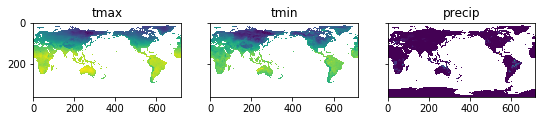

In [5]:
from osgeo import gdal
import matplotlib.pyplot as plt 

dataset = [('tmax',data1),('tmin',data2), ('precip',data)]
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
for i, (name, reg) in enumerate(dataset):
    axs[i].imshow(reg[name][1,:,:])
    axs[i].set_title(name)

In [4]:
#write tif
def writeTiff(im_data,im_width,im_height,im_bands,im_geotrans,im_proj,path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
    else:
        im_bands, (im_height, im_width) = 1,im_data.shape
        #创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, im_width, im_height, im_bands, datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #写入仿射变换参数
        dataset.SetProjection(im_proj) #写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset

In [28]:
from osgeo import gdal
ds = gdal.Open(r'G:\china_geodata\China_soil_1km\ChinaSoil_1km.tif')
prj = ds.GetProjection()
#tr = ds.GetGeoTransform()
tr = (0.25, 0.25, 0.0, 90, 0.0, -0.25)
writeTiff(data1['tmax'][180,:,:],720, 360, 1,tr, prj,r'G:\rice_china\ex.tif')

In [130]:
# create china point csv file
import pandas as pd

lat = data1['lat'][:]
lon = data1['lon'][:]
a = lat[lat>14.25]
lat_index = a[a <83.25]
b = lon[lon >73.325]
lon_index = b[b < 135.325]
x = []
y = []

for i in lon_index:
    for j in lat_index:
        x.append([i,j])
x = np.array(x)
x.shape
new_xy = pd.DataFrame()
new_xy['x'] = x[:,0]
new_xy['y'] = x[:,1]
new_xy.to_csv(r'G:\rice_china\xy.csv')

(16988, 2)

In [132]:
#[('tmax',data1),('tmin',data2), ('precip',data)]

In [144]:
#create point climate file for dndc
pt_ch = pd.read_csv(r'G:\rice_china\xy_china.csv')
fid = pt_ch['id']
x_ch = pt_ch['x']
y_ch = pt_ch['y']

climate = pd.DataFrame()
for id in fid:
    i = x_ch[id]
    j = y_ch[id]
    climate['jday'] = np.arange(1, 366, 1)
    climate['tmax'] = data1['tmax'][:,i, j]
    climate['tmin'] = data2['tmin'][:,i, j]
    climate['pre'] = data['precip'][:,i, j]/10 # cm in dnd unit
    climate.to_csv(r'G:\rice_china\climate\%d.csv'%id,index=False)

In [ ]:
111*0.5